In [1]:
"""
Climate Yield Prediction Model
-----------------------------
Este notebook implementa un modelo predictivo para rendimientos agrícolas basado en variables climáticas.

Características principales:
- Validación cruzada temporal
- Modelos: Linear Regression (baseline), Ridge, Random Forest, XGBoost
- Métricas: MAE, RMSE, R2
"""
## Importación de bibliotecas


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [2]:
## Carga y exploración de datos
# Cargamos el dataset preparado
df = pd.read_csv('datos_preparado.csv')

# Verificamos que los datos estén ordenados por producto y año
df = df.sort_values(by=['Producto', 'Año'])

# Verificamos las dimensiones
print(f"Dimensiones del DataFrame: {df.shape}")

# Examinamos los primeros registros
print("\nPrimeras filas:")
df.head()


Dimensiones del DataFrame: (5657, 28)

Primeras filas:


,Código del producto (CPC),Producto,Código del año,Año,Produccion(toneladas),Area_cosechada(ha),Rendimiento(kg/ha),temp_media,dias_calefaccion,dias_refrigeracion,...,rango_temp_media,temp_stress,helada_stress,temp_media_prev_year,dias_helada_prev_year,temp_max_prev_year,temp_min_prev_year,dias_calefaccion_prev_year,dias_refrigeracion_prev_year,rendimiento_prev_year
0,1450.0,"Aceitunas, olivas",1980,1980,2255000.0,1156500.0,1949.8,285.602374,1840.170131,167.406658,...,7.115642,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1450.0,"Aceitunas, olivas",1981,1981,1520800.0,2045000.0,743.7,286.153370,1701.725095,181.520258,...,7.484887,1,1,285.602374,46.084803,304.931822,267.255465,1840.170131,167.406658,1949.8
2,1450.0,"Aceitunas, olivas",1982,1982,3337900.0,2045800.0,1631.6,286.366110,1660.305388,201.588274,...,7.114025,1,1,286.153370,47.359136,304.518834,267.626369,1701.725095,181.520258,743.7
3,1450.0,"Aceitunas, olivas",1983,1983,1328400.0,2050400.0,647.9,286.225098,1689.456833,189.695727,...,7.571777,1,1,286.366110,39.719761,304.820828,270.616759,1660.305388,201.588274,1631.6
4,1450.0,"Aceitunas, olivas",1984,1984,3525400.0,2039100.0,1728.9,285.719600,1774.151377,153.548398,...,7.035220,1,1,286.225098,46.498697,305.865789,266.454933,1689.456833,189.695727,647.9


Distribución de productos únicos por año:
     Año  Cantidad de productos únicos
0   1961                            82
1   1962                            82
2   1963                            82
3   1964                            82
4   1965                            82
..   ...                           ...
58  2019                            77
59  2020                            77
60  2021                            78
61  2022                            77
62  2023                            77

[63 rows x 2 columns]


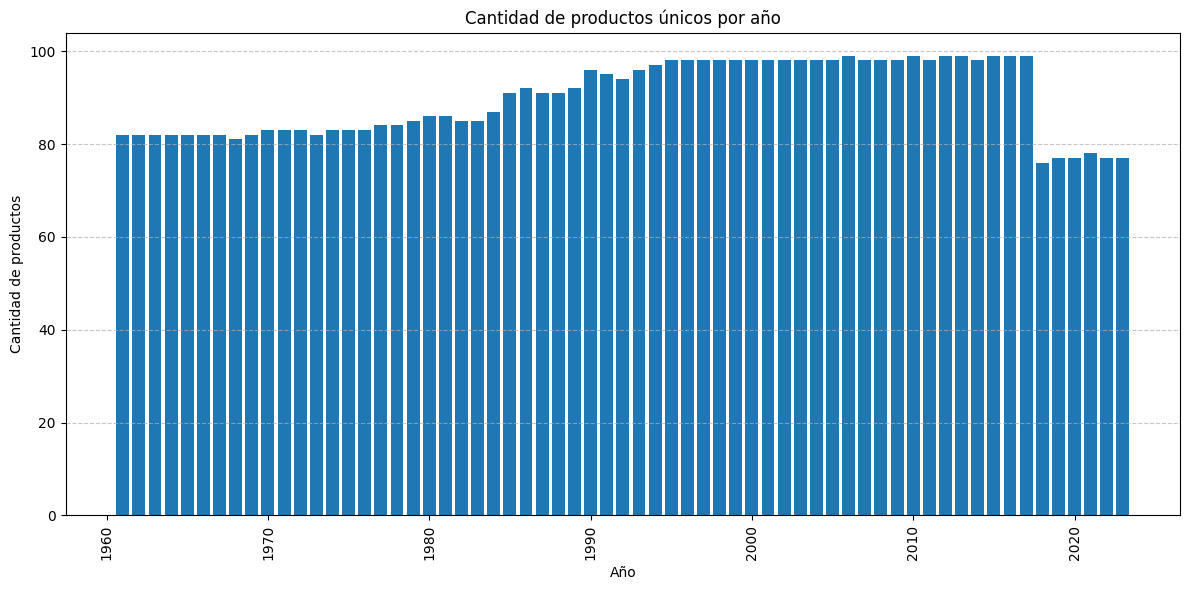


Valores nulos en columnas principales:
Año                        0
Producto                   0
Produccion(toneladas)      0
temp_media                 0
rendimiento_prev_year    105
dtype: int64

Estadísticas descriptivas de la producción:
count    5.657000e+03
mean     6.233138e+05
std      1.488252e+06
min      0.000000e+00
25%      1.142300e+04
50%      7.810000e+04
75%      4.074280e+05
max      1.207000e+07
Name: Produccion(toneladas), dtype: float64


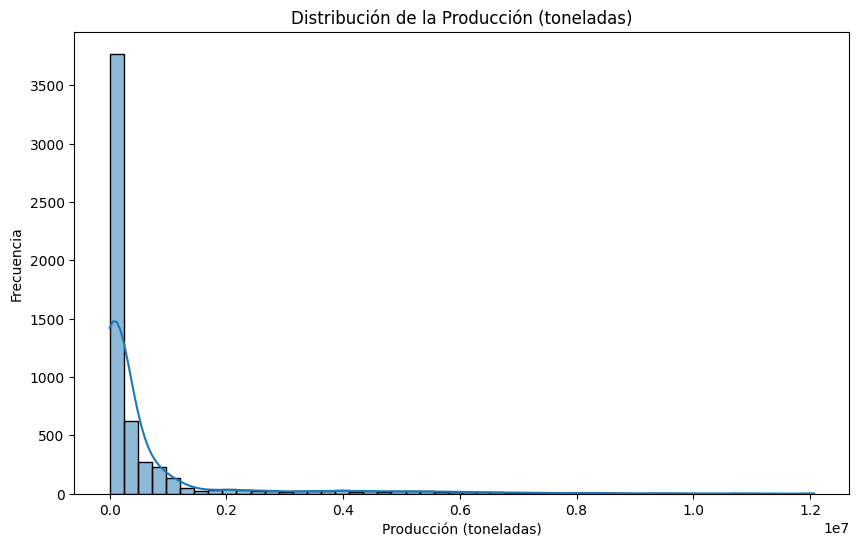

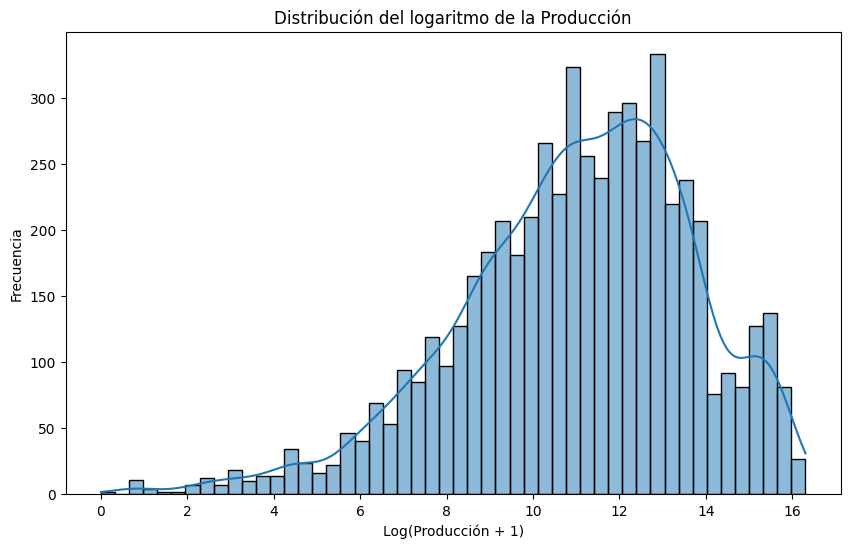

In [5]:
## Análisis de la estructura temporal de los datos

# Creamos una tabla con la distribución de productos por año
productos_por_año = df.groupby('Año')['Producto'].nunique().reset_index()
productos_por_año.columns = ['Año', 'Cantidad de productos únicos']

# Mostramos la tabla
print("Distribución de productos únicos por año:")
print(productos_por_año)

# Visualizamos la distribución
plt.figure(figsize=(12, 6))
plt.bar(productos_por_año['Año'], productos_por_año['Cantidad de productos únicos'])
plt.title('Cantidad de productos únicos por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de productos')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Comprobamos si hay valores nulos en las columnas principales
print("\nValores nulos en columnas principales:")
columnas_importantes = ['Año', 'Producto', 'Produccion(toneladas)', 'temp_media', 'rendimiento_prev_year']
print(df[columnas_importantes].isnull().sum())

# Estadísticas descriptivas de la variable objetivo
print("\nEstadísticas descriptivas de la producción:")
print(df['Produccion(toneladas)'].describe())

# Visualizamos la distribución de la variable objetivo
plt.figure(figsize=(10, 6))
sns.histplot(df['Produccion(toneladas)'], bins=50, kde=True)
plt.title('Distribución de la Producción (toneladas)')
plt.xlabel('Producción (toneladas)')
plt.ylabel('Frecuencia')
plt.show()

# Verificamos si hay una transformación logarítmica puede normalizar la distribución
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['Produccion(toneladas)']), bins=50, kde=True)
plt.title('Distribución del logaritmo de la Producción')
plt.xlabel('Log(Producción + 1)')
plt.ylabel('Frecuencia')
plt.show()


In [4]:
## Implementación de mejoras según el feedback

### 1. Incorporación de años anteriores para validación cruzada

# Función para generar características de años anteriores (lag features)
def generar_features_historicos(df, columnas_clima, n_years=3):
    """
    Genera características basadas en datos históricos de n años anteriores.
    
    Args:
        df: DataFrame con datos ordenados por producto y año
        columnas_clima: Lista de columnas climáticas para crear lag features
        n_years: Número de años anteriores a considerar
    
    Returns:
        DataFrame con nuevas características de años anteriores
    """
    # Hacemos una copia para no modificar el original
    df_new = df.copy()
    
    # Para cada producto, creamos características de años anteriores
    productos = df_new['Producto'].unique()
    
    all_dfs = []
    
    for producto in productos:
        df_prod = df_new[df_new['Producto'] == producto].copy()
        df_prod = df_prod.sort_values('Año')
        
        # Para cada año de lag (1 a n_years)
        for lag in range(1, n_years + 1):
            # Para rendimiento y producción anteriores
            df_prod[f'produccion_prev_{lag}_year'] = df_prod['Produccion(toneladas)'].shift(lag)
            df_prod[f'rendimiento_prev_{lag}_year'] = df_prod['Rendimiento(kg/ha)'].shift(lag)
            df_prod[f'area_prev_{lag}_year'] = df_prod['Area_cosechada(ha)'].shift(lag)
            
            # Para variables climáticas seleccionadas
            for col in columnas_clima:
                df_prod[f'{col}_prev_{lag}_year'] = df_prod[col].shift(lag)
        
        all_dfs.append(df_prod)
    
    # Combinamos todos los DataFrames
    result_df = pd.concat(all_dfs)
    
    # Eliminamos filas con NaN (serán los primeros n_years de cada producto)
    result_df = result_df.dropna()
    
    return result_df

# Columnas climáticas a considerar para generar lag features
columnas_clima = [
    'temp_media', 'dias_helada', 'temp_max', 'temp_min',
    'dias_calefaccion', 'dias_refrigeracion', 'temp_max_media', 
    'temp_min_media', 'rango_temp_anual', 'helada_stress'
]

# Generamos features de hasta 5 años anteriores
df_with_lags = generar_features_historicos(df, columnas_clima, n_years=5)

print(f"Dimensiones después de crear features de años anteriores: {df_with_lags.shape}")
print("\nNuevas columnas agregadas:")
new_cols = [col for col in df_with_lags.columns if 'prev' in col and 'prev_year' not in col]
print(new_cols)


Dimensiones después de crear features de años anteriores: (5132, 93)

Nuevas columnas agregadas:
['produccion_prev_1_year', 'rendimiento_prev_1_year', 'area_prev_1_year', 'temp_media_prev_1_year', 'dias_helada_prev_1_year', 'temp_max_prev_1_year', 'temp_min_prev_1_year', 'dias_calefaccion_prev_1_year', 'dias_refrigeracion_prev_1_year', 'temp_max_media_prev_1_year', 'temp_min_media_prev_1_year', 'rango_temp_anual_prev_1_year', 'helada_stress_prev_1_year', 'produccion_prev_2_year', 'rendimiento_prev_2_year', 'area_prev_2_year', 'temp_media_prev_2_year', 'dias_helada_prev_2_year', 'temp_max_prev_2_year', 'temp_min_prev_2_year', 'dias_calefaccion_prev_2_year', 'dias_refrigeracion_prev_2_year', 'temp_max_media_prev_2_year', 'temp_min_media_prev_2_year', 'rango_temp_anual_prev_2_year', 'helada_stress_prev_2_year', 'produccion_prev_3_year', 'rendimiento_prev_3_year', 'area_prev_3_year', 'temp_media_prev_3_year', 'dias_helada_prev_3_year', 'temp_max_prev_3_year', 'temp_min_prev_3_year', 'dias_

In [6]:
### 2. Preparación de características y target correctamente

# Definimos las características que usaremos para el modelo
# IMPORTANTE: Eliminamos características del mismo año que no estarían disponibles al momento de predecir

# Características climáticas del mismo año que NO podemos usar para predecir
caracteristicas_mismo_ano = [
    'temp_media', 'dias_calefaccion', 'dias_refrigeracion', 'dias_helada',
    'temp_max', 'temp_max_media', 'temp_max_min', 'temp_min_max', 
    'temp_min_media', 'temp_min', 'rango_temp_anual', 'rango_temp_media',
    'temp_stress', 'helada_stress', 'Area_cosechada(ha)', 'Rendimiento(kg/ha)'  
]

# Variables que sí podemos usar (años anteriores y características de producto)
caracteristicas = [col for col in df_with_lags.columns if any(s in col for s in ['prev_1', 'prev_2', 'prev_3', 'prev_4', 'prev_5'])]

# Agregamos características categóricas y de identificación
caracteristicas.append('Código del producto (CPC)')

# Variable objetivo (usamos transformación logarítmica para normalizar la distribución)
df_with_lags['log_produccion'] = np.log1p(df_with_lags['Produccion(toneladas)'])
y = df_with_lags['log_produccion']  # Usamos log para mejorar la distribución

# Características 
X = df_with_lags[caracteristicas]

print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

# Mostramos las primeras filas de X
X.head()


Dimensiones de X: (5132, 66)
Dimensiones de y: (5132,)


,produccion_prev_1_year,rendimiento_prev_1_year,area_prev_1_year,temp_media_prev_1_year,dias_helada_prev_1_year,temp_max_prev_1_year,temp_min_prev_1_year,dias_calefaccion_prev_1_year,dias_refrigeracion_prev_1_year,temp_max_media_prev_1_year,...,dias_helada_prev_5_year,temp_max_prev_5_year,temp_min_prev_5_year,dias_calefaccion_prev_5_year,dias_refrigeracion_prev_5_year,temp_max_media_prev_5_year,temp_min_media_prev_5_year,rango_temp_anual_prev_5_year,helada_stress_prev_5_year,Código del producto (CPC)
5,3525400.0,1728.9,2039100.0,285.719600,42.210031,305.231049,270.067672,1774.151377,153.548398,289.397374,...,46.084803,304.931822,267.255465,1840.170131,167.406658,289.336744,282.221102,37.676357,1.0,1450.0
6,1989500.0,970.0,2051000.0,286.124252,45.443254,305.589390,263.417360,1774.662644,214.348113,290.049869,...,47.359136,304.518834,267.626369,1701.725095,181.520258,290.060759,282.575872,36.892466,1.0,1450.0
7,2556800.0,1239.4,2063000.0,286.146364,44.838940,304.465144,267.356796,1739.040312,199.283900,289.955129,...,39.719761,304.820828,270.616759,1660.305388,201.588274,290.113220,282.999195,34.204069,1.0,1450.0
8,3879000.0,1885.8,2057000.0,286.276671,43.947476,305.407769,265.399466,1730.599560,229.059075,289.966064,...,46.498697,305.865789,266.454933,1689.456833,189.695727,290.215434,282.643657,39.410855,1.0,1450.0
9,2223700.0,1092.7,2035000.0,286.440905,41.521458,306.265635,269.510350,1659.621254,229.152372,290.232918,...,42.210031,305.231049,270.067672,1774.151377,153.548398,289.397374,282.362154,35.163377,1.0,1450.0


In [7]:
### 3. Función para evaluación correcta con validación cruzada temporal
def evaluar_modelo_cv_temporal(X, y, modelo, n_splits=5, transform_target=True):
    """
    Evalúa un modelo usando validación cruzada temporal.
    
    Args:
        X: Features
        y: Target (log-transformado)
        modelo: Modelo a evaluar
        n_splits: Número de divisiones para la validación cruzada
        transform_target: Si True, se aplica transformación inversa para métricas
    
    Returns:
        dict con métricas de evaluación
    """
    # Creamos el objeto TimeSeriesSplit para validación cruzada temporal
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Métricas para cada fold
    mse_scores = []
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    
    # Para cada split de validación cruzada
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Aplicamos StandardScaler SOLO a los datos de entrenamiento
        # y luego transformamos los datos de prueba con ese mismo scaler
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Entrenamos el modelo
        modelo.fit(X_train_scaled, y_train)
        
        # Predecimos
        y_pred_log = modelo.predict(X_test_scaled)
        
        # Si es necesario, aplicamos transformación inversa para calcular métricas en la escala original
        if transform_target:
            y_pred = np.expm1(y_pred_log)  # Transformación inversa de log1p
            y_test_original = np.expm1(y_test)
            
            # Calculamos métricas en escala original
            mse = mean_squared_error(y_test_original, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test_original, y_pred)
            r2 = r2_score(y_test_original, y_pred)
        else:
            # Calculamos métricas en escala logarítmica
            mse = mean_squared_error(y_test, y_pred_log)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred_log)
            r2 = r2_score(y_test, y_pred_log)
        
        # Guardamos métricas
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)
    
    # Retornamos las métricas promedio
    return {
        'MSE': np.mean(mse_scores),
        'RMSE': np.mean(rmse_scores),
        'MAE': np.mean(mae_scores),
        'R2': np.mean(r2_scores),
        'MSE_std': np.std(mse_scores),
        'RMSE_std': np.std(rmse_scores),
        'MAE_std': np.std(mae_scores),
        'R2_std': np.std(r2_scores)
    }



Evaluando modelo con 1 años anteriores...

Evaluando modelo con 2 años anteriores...

Evaluando modelo con 3 años anteriores...

Evaluando modelo con 4 años anteriores...

Evaluando modelo con 5 años anteriores...


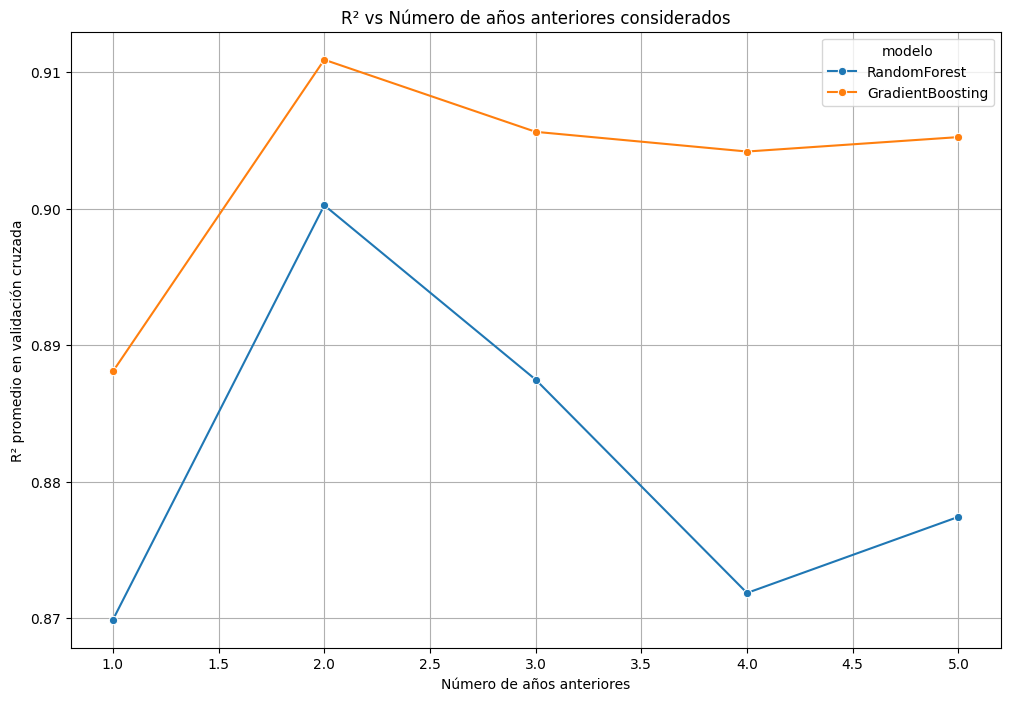

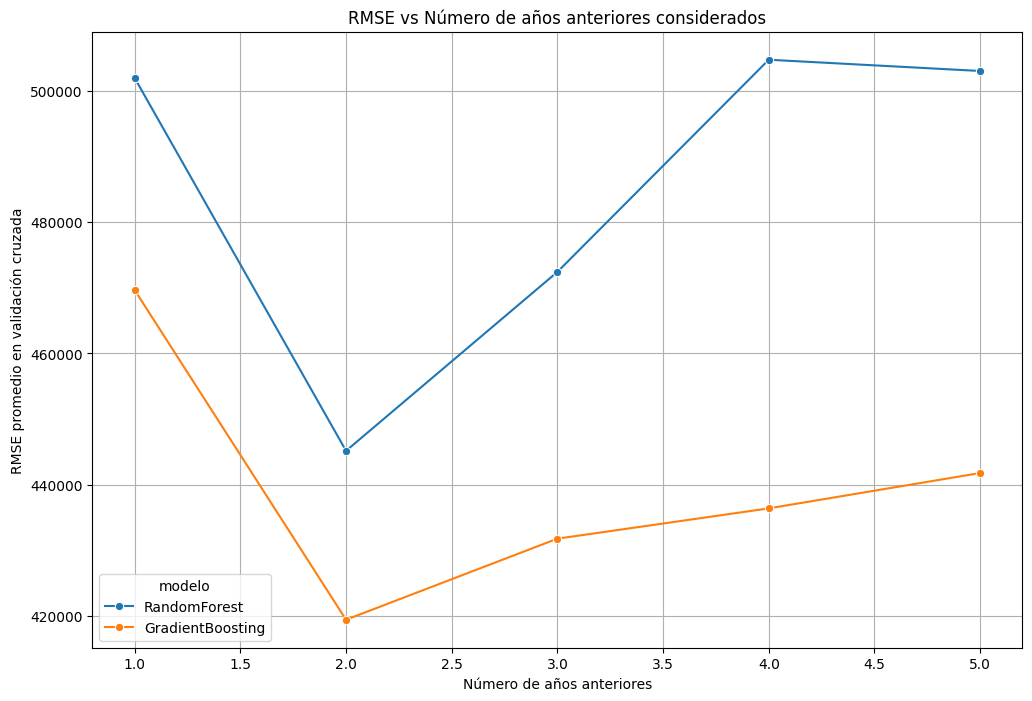


Resultados detallados:


,MSE,RMSE,MAE,R2,MSE_std,RMSE_std,MAE_std,R2_std,n_lags,modelo
0,5.611281e+11,501968.222054,180041.773353,0.869875,9.512084e+11,556018.022276,186341.627301,0.156696,1,RandomForest
1,4.952766e+11,469652.298069,162715.805002,0.888069,8.402265e+11,524121.498761,168740.269772,0.139871,1,GradientBoosting
2,4.105993e+11,445167.298136,154252.887281,0.900240,6.685004e+11,460896.323998,146066.217226,0.105171,2,RandomForest
3,3.707745e+11,419435.218206,143373.175678,0.910905,6.155813e+11,441416.627075,138109.073688,0.097480,2,GradientBoosting
4,4.819725e+11,472429.452104,164863.898770,0.887466,8.162368e+11,508707.145240,165200.980676,0.128623,3,RandomForest
5,3.970202e+11,431783.913309,149089.217938,0.905622,6.695973e+11,458893.120935,146023.598448,0.104532,3,GradientBoosting
6,5.921316e+11,504756.081174,178879.871156,0.871836,1.038535e+12,580820.924640,193863.590453,0.165184,4,RandomForest
7,4.112024e+11,436399.635125,151995.999152,0.904179,6.984899e+11,469848.611962,149757.967610,0.107693,4,GradientBoosting
8,5.656080e+11,503038.871589,177955.534272,0.877412,9.740527e+11,559070.598336,186460.422575,0.151068,5,RandomForest
9,4.096733e+11,441786.793328,154035.045039,0.905236,6.868122e+11,463138.947085,148846.971902,0.103208,5,GradientBoosting


In [8]:
### 4. Validación cruzada para determinar cuántos años atrás son útiles

# Vamos a evaluar diferentes combinaciones de años anteriores
# para determinar cuántos años atrás son útiles para el modelo

def evaluar_diferentes_lags(df, columnas_clima, max_lags=5):
    """
    Evalúa modelos con diferentes cantidades de años anteriores.
    
    Args:
        df: DataFrame con datos
        columnas_clima: Columnas climáticas a usar
        max_lags: Número máximo de años anteriores a evaluar
        
    Returns:
        DataFrame con resultados
    """
    resultados = []
    
    for n_lags in range(1, max_lags + 1):
        print(f"\nEvaluando modelo con {n_lags} años anteriores...")
        
        # Generamos features con n_lags años anteriores
        df_lags = generar_features_historicos(df, columnas_clima, n_years=n_lags)
        
        # Transformamos la variable objetivo
        df_lags['log_produccion'] = np.log1p(df_lags['Produccion(toneladas)'])
        
        # Seleccionamos características (solo de los años anteriores que estamos evaluando)
        caracteristicas = []
        for lag in range(1, n_lags + 1):
            lag_features = [col for col in df_lags.columns if f'prev_{lag}_year' in col]
            caracteristicas.extend(lag_features)
        
        caracteristicas.append('Código del producto (CPC)')
        
        # Preparamos X e y
        X = df_lags[caracteristicas]
        y = df_lags['log_produccion']
        
        # Evaluamos con Random Forest
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        metricas_rf = evaluar_modelo_cv_temporal(X, y, rf, transform_target=True)
        
        # Guardamos resultados
        metricas_rf['n_lags'] = n_lags
        metricas_rf['modelo'] = 'RandomForest'
        resultados.append(metricas_rf)
        
        # Evaluamos con Gradient Boosting
        gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
        metricas_gb = evaluar_modelo_cv_temporal(X, y, gb, transform_target=True)
        
        # Guardamos resultados
        metricas_gb['n_lags'] = n_lags
        metricas_gb['modelo'] = 'GradientBoosting'
        resultados.append(metricas_gb)
    
    # Convertimos a DataFrame
    df_resultados = pd.DataFrame(resultados)
    
    return df_resultados

# Evaluamos diferentes lags
resultados_lags = evaluar_diferentes_lags(df, columnas_clima, max_lags=5)

# Visualizamos los resultados
plt.figure(figsize=(12, 8))
sns.lineplot(data=resultados_lags, x='n_lags', y='R2', hue='modelo', marker='o')
plt.title('R² vs Número de años anteriores considerados')
plt.xlabel('Número de años anteriores')
plt.ylabel('R² promedio en validación cruzada')
plt.grid(True)
plt.show()

# Visualizamos el RMSE
plt.figure(figsize=(12, 8))
sns.lineplot(data=resultados_lags, x='n_lags', y='RMSE', hue='modelo', marker='o')
plt.title('RMSE vs Número de años anteriores considerados')
plt.xlabel('Número de años anteriores')
plt.ylabel('RMSE promedio en validación cruzada')
plt.grid(True)
plt.show()

# Mostramos tabla de resultados
print("\nResultados detallados:")
resultados_lags

In [9]:
### 5. Búsqueda de hiperparámetros más amplia con GridSearchCV correctamente implementada


# Determinamos el número óptimo de años anteriores basado en los resultados
# (Esta línea debe ser ajustada después de ver los resultados de la celda anterior)
mejor_n_lags = resultados_lags.loc[resultados_lags['R2'].idxmax()]['n_lags']
print(f"Número óptimo de años anteriores: {int(mejor_n_lags)}")

# Generamos el dataset con el número óptimo de años anteriores
df_optimal = generar_features_historicos(df, columnas_clima, n_years=int(mejor_n_lags))

# Transformamos la variable objetivo
df_optimal['log_produccion'] = np.log1p(df_optimal['Produccion(toneladas)'])

# Preparamos X e y
caracteristicas_optimal = []
for lag in range(1, int(mejor_n_lags) + 1):
    lag_features = [col for col in df_optimal.columns if f'prev_{lag}_year' in col]
    caracteristicas_optimal.extend(lag_features)

caracteristicas_optimal.append('Código del producto (CPC)')

X_optimal = df_optimal[caracteristicas_optimal]
y_optimal = df_optimal['log_produccion']

# Ahora implementamos GridSearchCV correctamente con el pipeline
# para asegurar que el scaler se aplique correctamente en cada fold

# Creamos el pipeline que incluye el scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

# Parámetros para búsqueda Grid - un rango más amplio
param_grid = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__max_depth': [None, 10, 20, 30, 40],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}

# Configuramos TimeSeriesSplit para validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# Ejecutamos GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Entrenamos
grid_search.fit(X_optimal, y_optimal)

# Mostramos los mejores parámetros
print("\nMejores hiperparámetros:")
print(grid_search.best_params_)

# Evaluamos el mejor modelo
mejor_modelo = grid_search.best_estimator_

# Hacemos una última validación cruzada con el mejor modelo
metricas_mejor_modelo = evaluar_modelo_cv_temporal(X_optimal, y_optimal, mejor_modelo, transform_target=True)

print("\nMétricas del mejor modelo:")
for metrica, valor in metricas_mejor_modelo.items():
    print(f"{metrica}: {valor:.4f}")


Número óptimo de años anteriores: 2
Fitting 5 folds for each of 540 candidates, totalling 2700 fits

Mejores hiperparámetros:
{'model__max_depth': 20, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 200}

Métricas del mejor modelo:
MSE: 417788514836.1029
RMSE: 446010.3764
MAE: 154435.2945
R2: 0.9004
MSE_std: 685782095989.0114
RMSE_std: 467828.2366
MAE_std: 148485.8319
R2_std: 0.1090


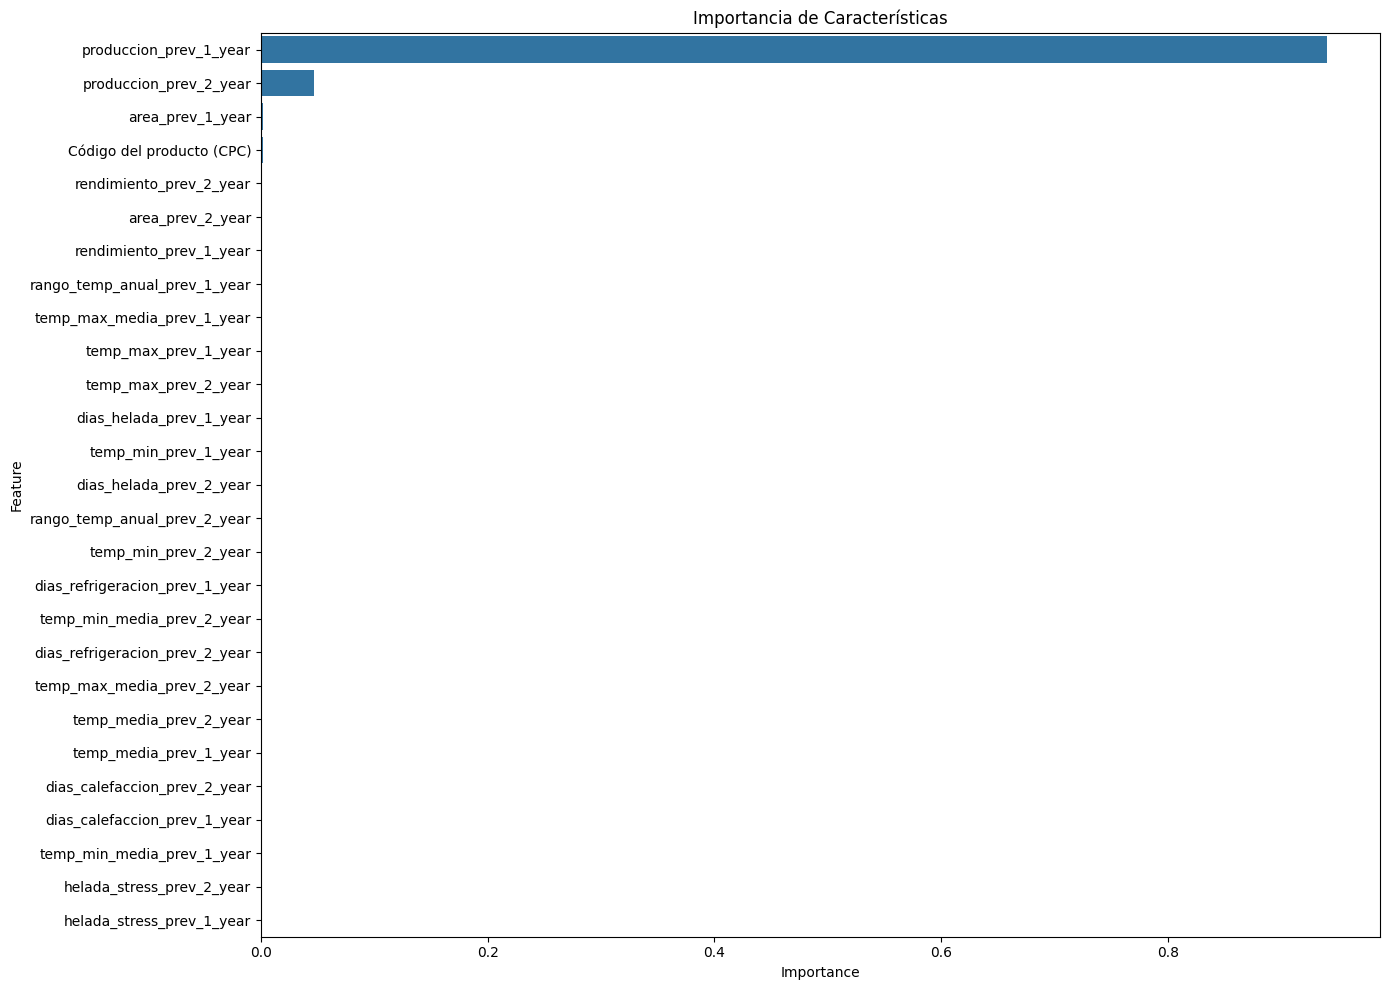


Importancia de características:


,Feature,Importance
0,produccion_prev_1_year,0.939956
13,produccion_prev_2_year,0.047048
2,area_prev_1_year,0.001793
26,Código del producto (CPC),0.001467
14,rendimiento_prev_2_year,0.000950
15,area_prev_2_year,0.000933
1,rendimiento_prev_1_year,0.000823
11,rango_temp_anual_prev_1_year,0.000572
9,temp_max_media_prev_1_year,0.000507
5,temp_max_prev_1_year,0.000505


In [10]:
### 6. Análisis de la importancia de características


# Obtenemos la importancia de características del mejor modelo
# Necesitamos extraer el modelo del pipeline
mejor_rf = mejor_modelo.named_steps['model']

# Obtenemos los nombres de las características (pueden cambiarse si se usó one-hot encoding)
feature_names = X_optimal.columns

# Obtenemos la importancia
importancia = mejor_rf.feature_importances_

# Creamos un DataFrame para visualizar
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importancia
})

# Ordenamos por importancia
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Visualizamos
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Importancia de Características')
plt.tight_layout()
plt.show()

# Mostramos tabla de importancia
print("\nImportancia de características:")
feature_importance.head(20)


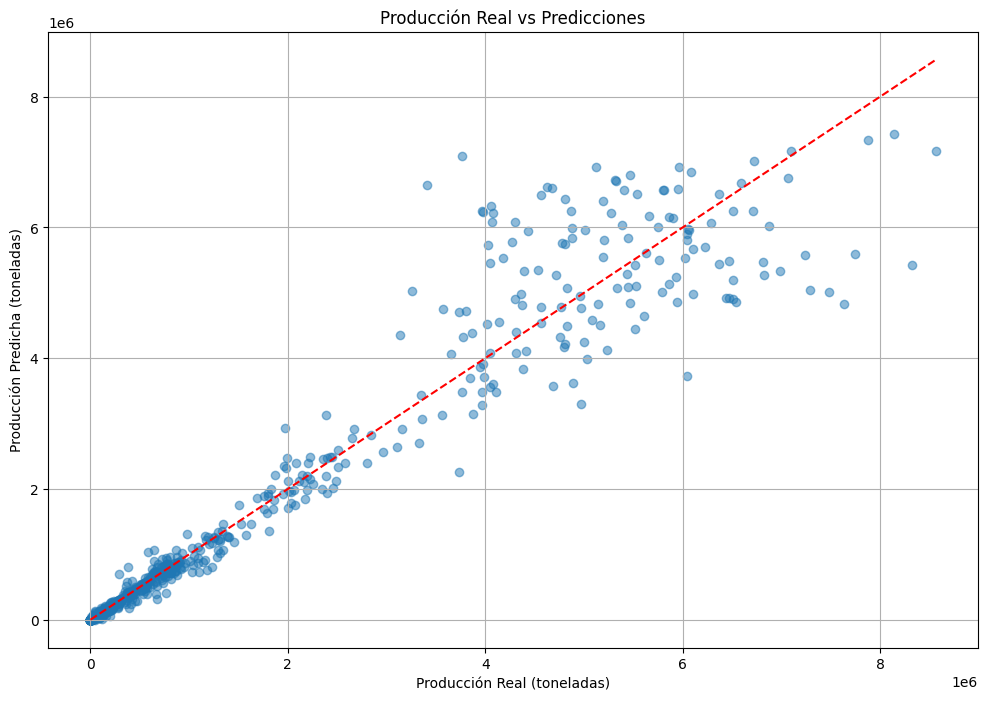

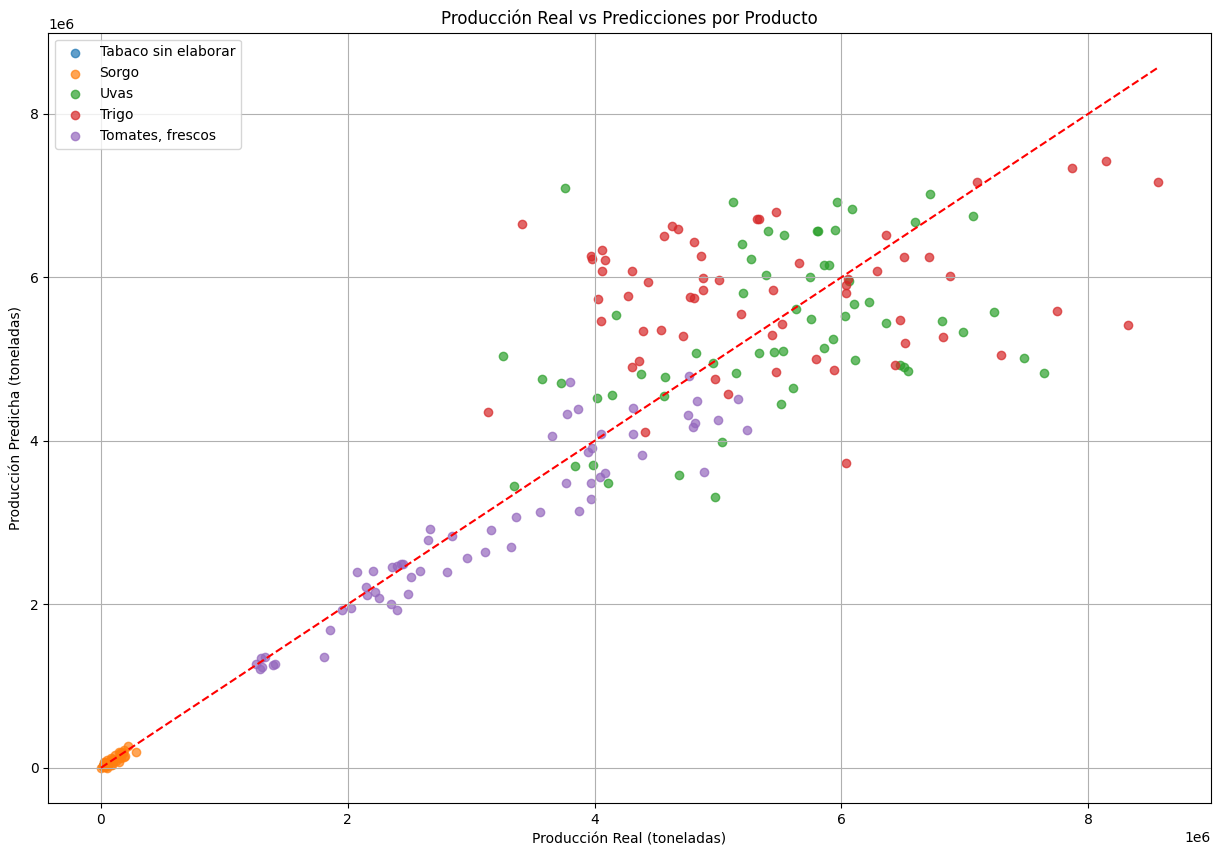

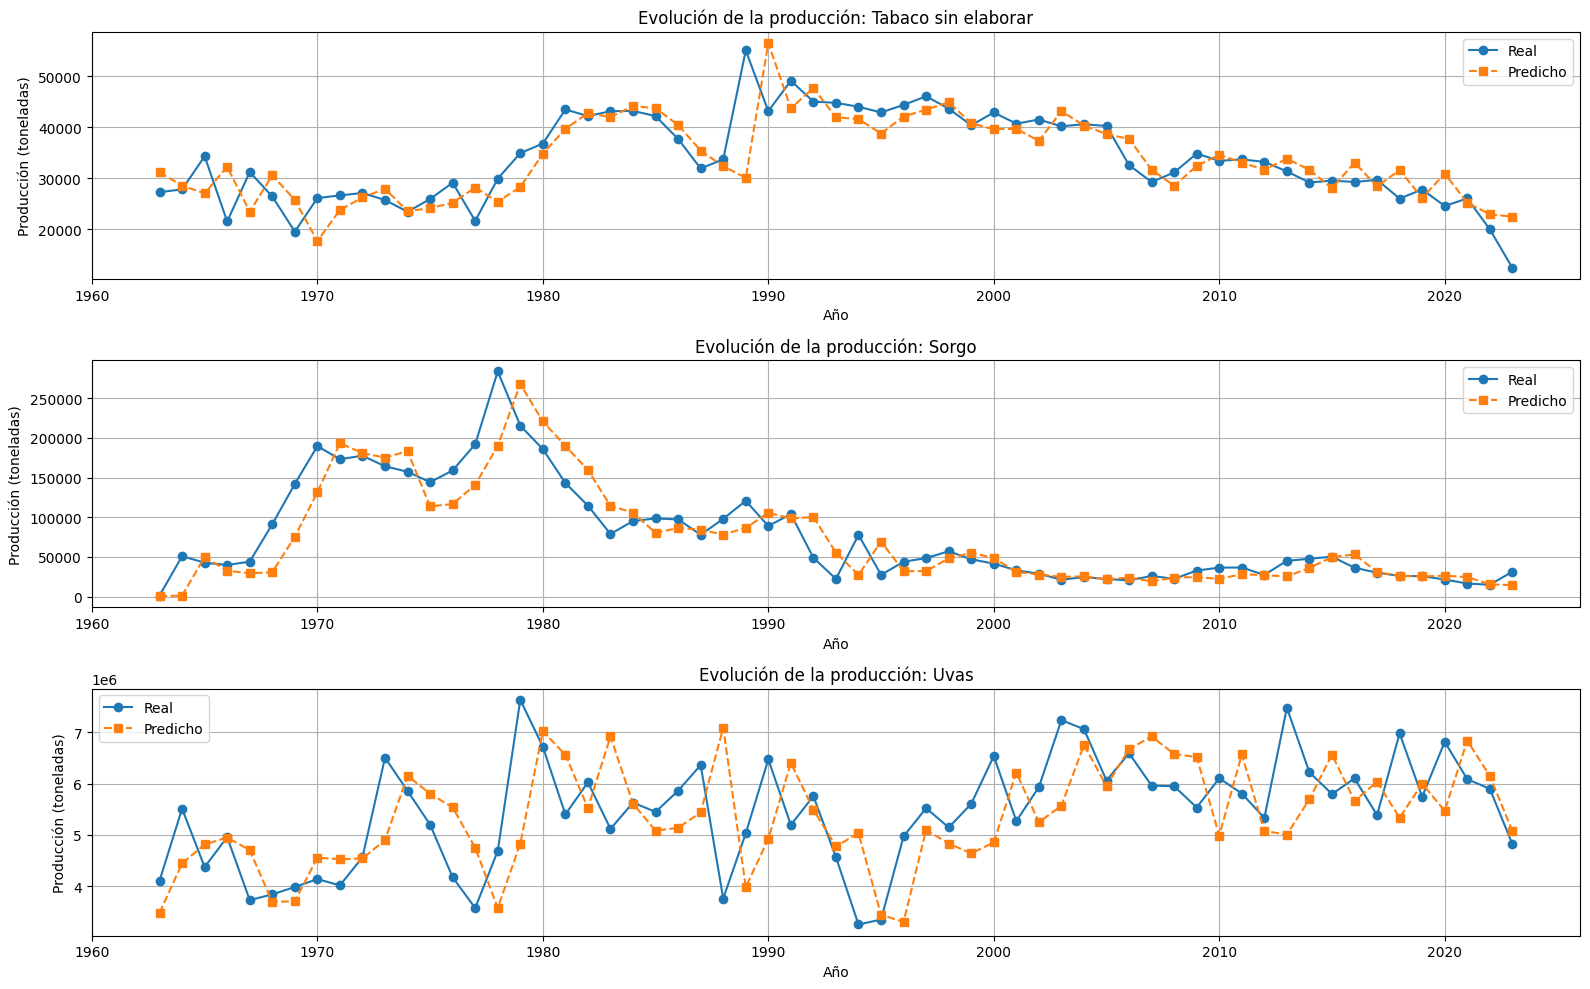

In [11]:
### 7. Visualización de predicciones vs valores reales

# Generamos predicciones finales para evaluar visualmente
# Usamos el último fold de TimeSeriesSplit para simular una situación real

tscv = TimeSeriesSplit(n_splits=5)
train_idx, test_idx = list(tscv.split(X_optimal))[-1]

X_train_final = X_optimal.iloc[train_idx]
X_test_final = X_optimal.iloc[test_idx]
y_train_final = y_optimal.iloc[train_idx]
y_test_final = y_optimal.iloc[test_idx]

# Entrenamos el mejor modelo
mejor_modelo.fit(X_train_final, y_train_final)

# Predecimos
y_pred_final_log = mejor_modelo.predict(X_test_final)

# Convertimos de vuelta a la escala original
y_pred_final = np.expm1(y_pred_final_log)
y_test_final_original = np.expm1(y_test_final)

# Preparamos datos para visualización
resultados_finales = pd.DataFrame({
    'Real': y_test_final_original,
    'Predicho': y_pred_final
})

# Agregamos información del producto
resultados_finales['Producto'] = df_optimal.iloc[test_idx]['Producto'].values
resultados_finales['Año'] = df_optimal.iloc[test_idx]['Año'].values

# Visualizamos predicciones vs valores reales
plt.figure(figsize=(12, 8))
plt.scatter(resultados_finales['Real'], resultados_finales['Predicho'], alpha=0.5)
plt.plot([0, resultados_finales['Real'].max()], [0, resultados_finales['Real'].max()], 'r--')
plt.title('Producción Real vs Predicciones')
plt.xlabel('Producción Real (toneladas)')
plt.ylabel('Producción Predicha (toneladas)')
plt.grid(True)
plt.show()

# Visualizamos predicciones para los 5 productos más comunes en los datos de test
top_productos = resultados_finales['Producto'].value_counts().nlargest(5).index

plt.figure(figsize=(15, 10))
for producto in top_productos:
    subset = resultados_finales[resultados_finales['Producto'] == producto]
    plt.scatter(subset['Real'], subset['Predicho'], label=producto, alpha=0.7)

plt.plot([0, resultados_finales['Real'].max()], [0, resultados_finales['Real'].max()], 'r--')
plt.title('Producción Real vs Predicciones por Producto')
plt.xlabel('Producción Real (toneladas)')
plt.ylabel('Producción Predicha (toneladas)')
plt.legend()
plt.grid(True)
plt.show()

# Visualizamos la evolución temporal de las predicciones para algunos productos seleccionados
plt.figure(figsize=(16, 10))

for producto in top_productos[:3]:  # Limitamos a 3 productos para mayor claridad
    subset = resultados_finales[resultados_finales['Producto'] == producto].sort_values('Año')
    
    plt.subplot(3, 1, list(top_productos[:3]).index(producto) + 1)
    plt.plot(subset['Año'], subset['Real'], 'o-', label='Real')
    plt.plot(subset['Año'], subset['Predicho'], 's--', label='Predicho')
    plt.title(f'Evolución de la producción: {producto}')
    plt.xlabel('Año')
    plt.ylabel('Producción (toneladas)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
### 8. Conclusiones y recomendaciones


# Calculamos métricas finales
mse_final = mean_squared_error(resultados_finales['Real'], resultados_finales['Predicho'])
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(resultados_finales['Real'], resultados_finales['Predicho'])
r2_final = r2_score(resultados_finales['Real'], resultados_finales['Predicho'])

# Calculamos MAPE (Mean Absolute Percentage Error)
# Evitamos división por cero
mask = resultados_finales['Real'] != 0
mape = np.mean(np.abs((resultados_finales.loc[mask, 'Real'] - resultados_finales.loc[mask, 'Predicho']) / resultados_finales.loc[mask, 'Real'])) * 100

print("Métricas finales en el conjunto de test:")
print(f"MSE: {mse_final:.2f}")
print(f"RMSE: {rmse_final:.2f}")
print(f"MAE: {mae_final:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2_final:.4f}")

# Características más importantes
print("\nLas 10 características más importantes:")
print(feature_importance.head(10))

# Resumen de mejoras implementadas
print("\nMejoras implementadas según el feedback del profesor:")
print("1. Inclusión de datos de múltiples años anteriores (no solo el año previo)")
print("2. Validación cruzada para determinar el número óptimo de años anteriores")
print("3. Eliminación de variables del mismo año que no estarían disponibles al momento de predecir")
print("4. Aplicación correcta del scaler dentro del proceso de validación cruzada")
print("5. Uso de TimeSeriesSplit para respetar la estructura temporal de los datos")
print("6. Ampliación del rango de hiperparámetros para buscar un mejor modelo predictivo")
print("7. Ordenamiento explícito de los datos por producto y año antes de la validación cruzada")
print("8. Transformación logarítmica de la variable objetivo para mejorar la distribución")

# Conclusiones
print("\nConclusiones:")
print(f"- El modelo óptimo utiliza datos de {int(mejor_n_lags)} años anteriores")
print("- La producción anterior y el área cosechada de años previos son predictores importantes")
print("- Las variables climáticas de años anteriores tienen un impacto en la producción")
print("- El modelo logra un R² de {:.4f}, explicando aproximadamente el {:.1f}% de la variabilidad en la producción".format(r2_final, r2_final*100))
print("- El error porcentual medio absoluto (MAPE) es de {:.2f}%".format(mape))
print("- La transformación logarítmica de la variable objetivo mejora el rendimiento del modelo")



Métricas finales en el conjunto de test:
MSE: 229980315016.87
RMSE: 479562.63
MAE: 191483.34
MAPE: 27.28%
R²: 0.9387

Las 10 características más importantes:
                         Feature  Importance
0         produccion_prev_1_year    0.939956
13        produccion_prev_2_year    0.047048
2               area_prev_1_year    0.001793
26     Código del producto (CPC)    0.001467
14       rendimiento_prev_2_year    0.000950
15              area_prev_2_year    0.000933
1        rendimiento_prev_1_year    0.000823
11  rango_temp_anual_prev_1_year    0.000572
9     temp_max_media_prev_1_year    0.000507
5           temp_max_prev_1_year    0.000505

Mejoras implementadas según el feedback del profesor:
1. Inclusión de datos de múltiples años anteriores (no solo el año previo)
2. Validación cruzada para determinar el número óptimo de años anteriores
3. Eliminación de variables del mismo año que no estarían disponibles al momento de predecir
4. Aplicación correcta del scaler dentro del proce

In [13]:
## Guardar el modelo
# Guardar el modelo para uso futuro
import joblib

# Guardamos el mejor modelo
joblib.dump(mejor_modelo, 'mejor_modelo_produccion.pkl')

# Guardamos también la lista de características para referencia futura
with open('caracteristicas_modelo.txt', 'w') as f:
    for feature in feature_names:
        f.write(f"{feature}\n")

print("Modelo y características guardados exitosamente.")

Modelo y características guardados exitosamente.


In [14]:
# Exportar datos para Power BI
print("\n## Exportando datos para Power BI ##")

# 1. Exportar resultados de predicciones con datos enriquecidos
resultados_power_bi = resultados_finales.copy()

# Añadir métricas de error por registro
resultados_power_bi['Error_Absoluto'] = abs(resultados_power_bi['Real'] - resultados_power_bi['Predicho'])
resultados_power_bi['Error_Porcentual'] = abs(resultados_power_bi['Real'] - resultados_power_bi['Predicho']) / resultados_power_bi['Real'] * 100
resultados_power_bi['Error_Porcentual'] = resultados_power_bi['Error_Porcentual'].fillna(0)  # Para evitar division por cero

# Añadir información de región (simulada para el ejemplo - ajustar según tus datos)
# Esto enriquece los datos para posibles visualizaciones geográficas en Power BI
productos_por_region = {
    # Esto es un ejemplo - deberás adaptarlo a tus datos reales
    'Aceitunas, olivas': 'Sur',
    'Aguacates': 'Centro',
    'Ajo verde': 'Norte',
    'Almendras con cáscara': 'Este',
    'Arándanos': 'Norte',
    # Añadir el resto de productos...
}

# Aplicar mapeo (con valor por defecto 'No asignado' para productos sin región)
resultados_power_bi['Region'] = resultados_power_bi['Producto'].map(
    lambda x: productos_por_region.get(x, 'No asignado')
)

# Guardar los resultados de predicciones
resultados_power_bi.to_csv('resultados_predicciones_para_powerbi.csv', index=False)
print("✓ Resultados de predicciones exportados a 'resultados_predicciones_para_powerbi.csv'")




## Exportando datos para Power BI ##
✓ Resultados de predicciones exportados a 'resultados_predicciones_para_powerbi.csv'


In [15]:
# 2. Exportar métricas de evaluación
metricas_dict = {
    'Metrica': ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2'],
    'Valor': [mse_final, rmse_final, mae_final, mape, r2_final]
}
metricas_df = pd.DataFrame(metricas_dict)
metricas_df.to_csv('metricas_modelo_para_powerbi.csv', index=False)
print("✓ Métricas del modelo exportadas a 'metricas_modelo_para_powerbi.csv'")



✓ Métricas del modelo exportadas a 'metricas_modelo_para_powerbi.csv'


In [16]:
# 3. Exportar importancia de características
feature_importance.to_csv('importancia_caracteristicas_para_powerbi.csv', index=False)
print("✓ Importancia de características exportada a 'importancia_caracteristicas_para_powerbi.csv'")



✓ Importancia de características exportada a 'importancia_caracteristicas_para_powerbi.csv'


In [17]:
# 4. Crear y exportar datos históricos con predicciones para visualización temporal
# Primero, obtenemos predicciones para todo el dataset
df_completo = df_optimal.copy()

# Preparamos X para todo el dataset
X_completo = df_completo[caracteristicas_optimal]
X_completo_scaled = mejor_modelo.named_steps['scaler'].transform(X_completo)

# Realizamos predicciones
predicciones_log_completo = mejor_modelo.named_steps['model'].predict(X_completo_scaled)
predicciones_completo = np.expm1(predicciones_log_completo)

# Creamos DataFrame con datos históricos y predicciones
historico_predicciones = pd.DataFrame({
    'Año': df_completo['Año'],
    'Producto': df_completo['Producto'],
    'Produccion_Real': df_completo['Produccion(toneladas)'],
    'Produccion_Predicha': predicciones_completo,
    'Area_Cosechada': df_completo['Area_cosechada(ha)'],
    'Rendimiento': df_completo['Rendimiento(kg/ha)']
})

# Añadir indicadores de error
historico_predicciones['Error_Absoluto'] = abs(historico_predicciones['Produccion_Real'] - historico_predicciones['Produccion_Predicha'])
historico_predicciones['Error_Porcentual'] = abs(historico_predicciones['Produccion_Real'] - historico_predicciones['Produccion_Predicha']) / historico_predicciones['Produccion_Real'] * 100
historico_predicciones['Error_Porcentual'] = historico_predicciones['Error_Porcentual'].fillna(0)

# Guardar para Power BI
historico_predicciones.to_csv('historico_predicciones_para_powerbi.csv', index=False)
print("✓ Histórico de predicciones exportado a 'historico_predicciones_para_powerbi.csv'")



✓ Histórico de predicciones exportado a 'historico_predicciones_para_powerbi.csv'


In [18]:
# 5. Crear tablas auxiliares para mejorar el modelo de datos en Power BI
# Tabla de productos con información adicional
productos_df = pd.DataFrame({
    'Producto': df['Producto'].unique(),
    'Codigo_Producto': [df[df['Producto'] == p]['Código del producto (CPC)'].values[0] 
                        for p in df['Producto'].unique()],
})
productos_df['Region'] = productos_df['Producto'].map(lambda x: productos_por_region.get(x, 'No asignado'))
productos_df.to_csv('tabla_productos_para_powerbi.csv', index=False)
print("✓ Tabla de productos exportada a 'tabla_productos_para_powerbi.csv'")

# Tabla de tiempo para facilitar análisis temporales en Power BI
años = sorted(df['Año'].unique())
tiempo_df = pd.DataFrame({
    'Año': años,
    'Década': [str(año // 10 * 10) + 's' for año in años],
    'Es_Ultimo_Año': [año == max(años) for año in años]
})
tiempo_df.to_csv('tabla_tiempo_para_powerbi.csv', index=False)
print("✓ Tabla de tiempo exportada a 'tabla_tiempo_para_powerbi.csv'")

print("\nTodos los archivos para Power BI han sido generados correctamente.")
print("Puedes importarlos directamente en Power BI para crear tu dashboard.")


✓ Tabla de productos exportada a 'tabla_productos_para_powerbi.csv'
✓ Tabla de tiempo exportada a 'tabla_tiempo_para_powerbi.csv'

Todos los archivos para Power BI han sido generados correctamente.
Puedes importarlos directamente en Power BI para crear tu dashboard.


In [19]:
## Sugerencias para el dashboard en Power BI
# Estas son algunas sugerencias que puedes implementar en tu dashboard de Power BI

print("\n## Ideas para el dashboard en Power BI ##")
print("""
1. Página principal:
   - KPI con métricas clave del modelo (R², MAPE)
   - Gráfico de líneas con producción histórica vs. predicciones
   - Mapa con producción por región
   - Top 5 productos más rentables

2. Página de análisis por producto:
   - Selector de producto
   - Gráfico de líneas de producción histórica y predicción futura
   - Gráfico de barras con rendimiento por hectárea
   - Indicadores de crecimiento interanual

3. Página de análisis de factores:
   - Gráfico de barras con importancia de características
   - Scatter plot de relación entre variables climáticas y producción
   - Heat map de correlaciones entre variables

4. Página de predicciones futuras:
   - Proyecciones de producción para próximos años
   - Análisis de escenarios (optimista, pesimista, neutro)
   - Comparativa con competidores o mercado global
""")



## Ideas para el dashboard en Power BI ##

1. Página principal:
   - KPI con métricas clave del modelo (R², MAPE)
   - Gráfico de líneas con producción histórica vs. predicciones
   - Mapa con producción por región
   - Top 5 productos más rentables

2. Página de análisis por producto:
   - Selector de producto
   - Gráfico de líneas de producción histórica y predicción futura
   - Gráfico de barras con rendimiento por hectárea
   - Indicadores de crecimiento interanual

3. Página de análisis de factores:
   - Gráfico de barras con importancia de características
   - Scatter plot de relación entre variables climáticas y producción
   - Heat map de correlaciones entre variables

4. Página de predicciones futuras:
   - Proyecciones de producción para próximos años
   - Análisis de escenarios (optimista, pesimista, neutro)
   - Comparativa con competidores o mercado global

